In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Pytorch ImageFolder 객체에 맞도록 datafolder 구성 (레이블 필요한 경우)

In [ ]:
# filename 에 class 가 바로 대응된 dictionary 파일 읽어옴
import pickle

# dataset에서 file들 가져옴 
import os
import shutil

with open('/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pFileNameToClass.pickle','rb') as fw:
    pFileNameToClass = pickle.load(fw) # O(1) 로 바로 class 찾을 수 있다.

# 인쇄체 데이터 모은 폴더의 이미지들 file list 받음
path = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/printed"
file_list = os.listdir(path) # 35765 -> augmentation 필요

# imageFolder 객체에 맞도록 datafolder 구성
pretrain_dir_path = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pretrainDataset"
os.makedirs(pretrain_dir_path, exist_ok=True)

for filename in file_list:
    label = pFileNameToClass[filename]
    folder_path = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pretrainDataset/" + str(label)
    os.makedirs(folder_path, exist_ok=True)
    shutil.move(path + '/' + filename, folder_path + '/' + filename)

## Pretrain_DataLoader

#### OSError: errno 5 input/output error 해결하기

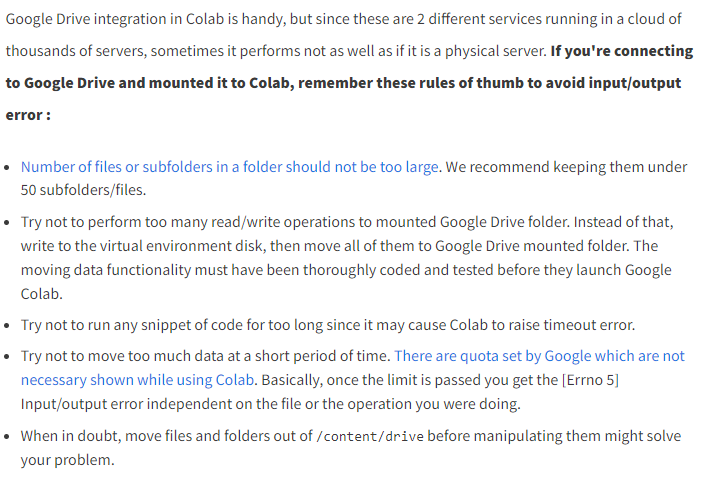

In [ ]:
import os
import shutil

# colab VM disc 사용
dir_path = "/content/data/printed"
os.makedirs(dir_path, exist_ok=True)

# 공유 드라이브의 데이터를 복사해 생성하기
driveFolder = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/printed'
newFolder = '/content/data/printed'
shutil.copytree(driveFolder, newFolder)

OSError: ignored

In [ ]:
path = "/content/data/printed"
file_list = os.listdir(path) # 35765 -> augmentation 필요
len(file_list)

0

### DataLoader

In [2]:
!unzip '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pretrain/preprocessed.zip' -d .

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./preprocessed/00141873.png  
  inflating: ./preprocessed/00228232.png  
  inflating: ./preprocessed/00050363.png  
  inflating: ./preprocessed/00296008.png  
  inflating: ./preprocessed/00308880.png  
  inflating: ./preprocessed/00473574.png  
  inflating: ./preprocessed/00092955.png  
  inflating: ./preprocessed/00192494.png  
  inflating: ./preprocessed/00115889.png  
  inflating: ./preprocessed/00325591.png  
  inflating: ./preprocessed/00083227.png  
  inflating: ./preprocessed/00272463.png  
  inflating: ./preprocessed/00038818.png  
  inflating: ./preprocessed/00249872.png  
  inflating: ./preprocessed/00330932.png  
  inflating: ./preprocessed/00255102.png  
  inflating: ./preprocessed/00140215.png  
  inflating: ./preprocessed/00417378.png  
  inflating: ./preprocessed/00430143.png  
  inflating: ./preprocessed/00155671.png  
  inflating: ./preprocessed/00043819.png  
  inflating: ./preprocessed/00330123.png  
  inflating: ./pre

./preprocessed/00388007.png Size: (88, 93)


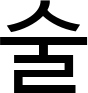

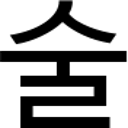

In [3]:
from PIL import Image, ImageOps

filePath = './preprocessed/00388007.png' 
image=Image.open(filePath)
image.load()
imageSize = image.size
print(filePath, "Size:", imageSize)

display(image)
bigger = image.resize((128, 128))
display(bigger)

In [4]:
from PIL import Image
import os

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [5]:
class SyllablePrintedDataset(Dataset):
    def __init__(self, path, transform):        
        file_list = []
        for filename in os.listdir(path):
            fileName = path + '/' + filename
            file_list.append(fileName)        

        self.transform = transform
        self.dataset = []
        for img_path in file_list[:]:
            image = Image.open(img_path)
            img_transformed = self.transform(image)
            self.dataset.append(img_transformed)

    def __len__(self):
      return len(self.dataset)

    def __getitem__(self, index):
      return self.dataset[index]

In [ ]:
# # dataloader test 
# transform = transforms.Compose([
#                                 transforms.Resize((64,64)),
#                                 transforms.RandomAffine(30),
#                                 transforms.ColorJitter(brightness=(0.2, 1.5), 
#                                                        contrast=(0.2, 3), 
#                                                        saturation=(0.2, 1.5)),
#                                 transforms.ToTensor(),
#                                 ])
# folderpath = '/content/preprocessed'
# dataset = SyllablePrintedDataset(folderpath, transform)

# print("학습에 사용하는 데이터 수 : ", dataset.__len__())

# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
# # dataloader test
# for imgs in dataloader: # 배치 단위로 iter
#   print(".")

.
.


## SelfAttentionGAN with Wasserstein Loss Model

In [6]:
import math
import sys
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch


output_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/outputs/SelfAttention_Wasserstein'
os.makedirs(output_path, exist_ok=True)

g_lossL = []
d_lossL = []

In [7]:
class Opt:
    def __init__(self, epoch=1000, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, n_cpu=2, latent_dim=100, img_size=128, channels=3, n_critic=5, clip_value=0.01, sample_interval=400):
        self.n_epochs = epoch              # number of epochs of training
        self.batch_size = batch_size    # size of the batches
        self.lr = lr                    # adam: learning rate
        self.b1 = b1                    # adam: decay of first order momentum of gradient
        self.b2 = b2                    # adam: decay of first order momentum of gradient
        self.n_cpu = n_cpu              # number of cpu threads to use during batch generation
        self.latent_dim = latent_dim    # dimensionality of the latent space
        self.img_size = img_size        # size of each image dimension
        self.channels = channels        # number of image channels
        self.n_critic = n_critic        # number of training steps for discriminator per iter
        self.clip_value = clip_value    # lower and upper clip value for disc. weights
        self.sample_interval = sample_interval # interval between image sampling
opt = Opt() 

img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False

In [8]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [9]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

In [10]:
class Generator(nn.Module):
    """Generator."""

    def __init__(self, batch_size=opt.batch_size, image_size=opt.img_size, z_dim=opt.latent_dim, conv_dim=64):
        super(Generator, self).__init__()
        self.imsize = image_size 
        layer1 = []
        layer2 = []
        layer3 = []
        layer4 = []
        last = []

        repeat_num = int(np.log2(self.imsize)) - 4
        mult = 2 ** repeat_num # 8
        layer1.append(SpectralNorm(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.ReLU())

        curr_dim = conv_dim * mult

        layer2.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.ReLU())

        curr_dim = int(curr_dim / 2)

        layer3.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.ReLU())
        
        curr_dim = int(curr_dim / 2)

        layer4.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer4.append(nn.ReLU())
        
        curr_dim = int(curr_dim / 2)

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)
        self.l4 = nn.Sequential(*layer4) # 이미지 크기가 64인 경우 
        # in_channels, out_channels, kernel_size, stride=1, padding=0
        last.append(nn.ConvTranspose2d(curr_dim, out_channels=3, kernel_size=4, stride=4, padding=0)) #
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn( 128, 'relu')


    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z) # 입력 : torch.Size([30, 100, 1, 1])
        # torch.Size([30, 512, 4, 4])
        out=self.l2(out)
        # torch.Size([30, 256, 8, 8])
        out=self.l3(out)
        #  torch.Size([30, 128, 16, 16])
        out,p1 = self.attn1(out)
        # torch.Size([30, 128, 16, 16]) 
        out=self.l4(out) 
        # torch.Size([30, 64, 32, 32]) 
        out=self.last(out)  
        # torch.Size([30, 3, 128, 128])
        return out, p1

In [11]:
class Discriminator(nn.Module):
    """Discriminator, Auxiliary Classifier."""

    def __init__(self, batch_size=opt.batch_size, image_size=opt.img_size, conv_dim=64):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(SpectralNorm(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))

        curr_dim = conv_dim

        layer2.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.Conv2d(curr_dim, 1, 16))
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(128, 'relu')


    def forward(self, x): 
        out = self.l1(x)
        # torch.Size([30, 64, 64, 64])
        out = self.l2(out)
        # torch.Size([30, 128, 32, 32])
        out,p1 = self.attn1(out)
        # torch.Size([30, 128, 32, 32])
        out = self.l3(out)
        # torch.Size([30, 256, 16, 16])
        out=self.last(out)
        # torch.Size([30, 1, 1, 1])
        return out.view(-1, 1), p1

In [12]:
k = 2
p = 6

generator_out_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/model/SelfAttention_Wasserstein/generator.pth'
discriminator_out_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/model/SelfAttention_Wasserstein/discriminator.pth'

# Initialize generator and discriminator
generator = Generator().cuda()
checkpoint_gen = torch.load(generator_out_path)
generator.load_state_dict(checkpoint_gen, strict=True)
print(generator)

discriminator = Discriminator().cuda()
checkpoint_dis = torch.load(discriminator_out_path)
discriminator.load_state_dict(checkpoint_dis, strict=True)
print(discriminator)

# 수정
transform = transforms.Compose([
                                transforms.Resize((128,128)),
                                # transforms.RandomAffine(30),
                                # transforms.ColorJitter(brightness=(0.2, 1.5), 
                                #                        contrast=(0.2, 1.5), 
                                #                        saturation=(0.2, 1.5)),
                                transforms.ToTensor(),
                                ])
folderpath = '/content/preprocessed'
dataset = SyllablePrintedDataset(folderpath, transform)
print("학습에 사용하는 데이터 수 : ", dataset.__len__())

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Generator(
  (l1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l4): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )

In [13]:
# ----------
#  Training
# ----------

batches_done = 0
for epoch in range(opt.n_epochs):
    for i, imgs in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input       
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim)))) 

        # Generate a batch of images
        fake_imgs, gattn1 = generator(z)

        # Real images
        real_validity, dattnr1 = discriminator(real_imgs)
        # Fake images
        fake_validity, dattnf1= discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs, _ = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity, _ = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)
            g_loss.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch+1, opt.n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
            )

            if batches_done % opt.sample_interval == 0: 
                save_image(fake_imgs.data[:25], "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/outputs/SelfAttention_Wasserstein/images/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done += opt.n_critic
    
    # epoch 끝날 떄 마다 저장하기
    torch.save(generator.state_dict(), generator_out_path)
    torch.save(discriminator.state_dict(), discriminator_out_path)
    g_lossL.append(g_loss)
    d_lossL.append(d_loss)

[Epoch 1/1000] [Batch 1/945] [D loss: -8.882414] [G loss: -4.550977]
[Epoch 1/1000] [Batch 6/945] [D loss: -9.079376] [G loss: -4.640634]
[Epoch 1/1000] [Batch 11/945] [D loss: -9.963377] [G loss: -4.356776]
[Epoch 1/1000] [Batch 16/945] [D loss: -9.996122] [G loss: -4.832881]
[Epoch 1/1000] [Batch 21/945] [D loss: -8.547283] [G loss: -4.844296]
[Epoch 1/1000] [Batch 26/945] [D loss: -9.426260] [G loss: -6.435713]
[Epoch 1/1000] [Batch 31/945] [D loss: -9.814826] [G loss: -2.137788]
[Epoch 1/1000] [Batch 36/945] [D loss: -9.621025] [G loss: 0.380446]
[Epoch 1/1000] [Batch 41/945] [D loss: -11.823733] [G loss: -1.252710]
[Epoch 1/1000] [Batch 46/945] [D loss: -9.522694] [G loss: -1.526647]
[Epoch 1/1000] [Batch 51/945] [D loss: -9.783552] [G loss: -0.848982]
[Epoch 1/1000] [Batch 56/945] [D loss: -9.236124] [G loss: -3.507643]
[Epoch 1/1000] [Batch 61/945] [D loss: -8.650970] [G loss: -3.474254]
[Epoch 1/1000] [Batch 66/945] [D loss: -9.172087] [G loss: -3.769124]
[Epoch 1/1000] [Batch 

KeyboardInterrupt: ignored

In [14]:
import csv 
with open('/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/outputs/SelfAttention_Wasserstein/loss/SelfAttention_Wasserstein_lossFile2.csv', 'w', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(g_lossL) 
    writer.writerow(d_lossL) 

### github 커밋

In [15]:
MY_GOOGLE_DRIVE_PATH = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital"
%cd "{MY_GOOGLE_DRIVE_PATH}"

/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital


In [16]:
!git config --global user.email dkwjd0824@khu.ac.kr  # 이메일 입력 ex) qhrqufdlek@naver.com
!git config --global user.name  hyeneung #깃헙 아이디 입력 ex)luckydipper
!git pull

Already up to date.


In [ ]:
!git status

In [ ]:
!git add GAN/selfAttentionGAN.ipynb

In [ ]:
!git commit -m"[ADD] finish pretrain"

[main d3b8107] [ADD] modelSave and Load
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite GAN/selfAttentionGAN.ipynb (84%)


In [ ]:
!git push

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 2.14 KiB | 168.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/PILGI-Analog-To-Digital/Analog-PILGI-to-DIgital.git
   2e4617c..d3b8107  main -> main
